In [1]:
%cd ../

/home/tadenoud/Git/simple-faster-rcnn-pytorch


In [2]:
RANDOM_SEED = 42
SUBSET_SAMPLE_DATA_PERCENTAGE = 0.1
MIN_IOU_REQUIRED = 0.7  # The minimum IOU required to be a good detection (ie higher is more strict)
NUM_PROPOSALS = 300
CHECKPOINT_DIR = './idd_fn_detection'

%load_ext autoreload
%autoreload 2

import os
import torch as t
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
import numpy as np
import pickle
import h5py
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
from utils.config import opt
from utils.idd_utils import get_annotations
from model.utils.bbox_tools import bbox_iou

from data.dataset import Dataset, TestDataset, KittiDataset
from torch.utils.data import DataLoader
from utils.vis_tool import vis_bbox, vis_image
from utils.idd_utils import IndiaDrivingDataset
from ood_metrics import auroc, plot_roc, calc_metrics
from sklearn import svm
import pickle
import itertools
import torch
from model.faster_rcnn import nograd
from data.dataset import preprocess
from utils.mahalanobis import Mahal_Dist


import warnings
warnings.filterwarnings(action='once')

np.random.seed(RANDOM_SEED)

In [3]:
%matplotlib inline

In [4]:
fg_detections = 13115
bg_detections = 292551

data_portion = fg_detections / bg_detections
print(data_portion)

0.0448297903613387


In [5]:
opt.voc_data_dir = "./datasets/kitti_2d/VOC2012/"
idd_data_dir = "./datasets/idd_detection/"

# Subsample full dataset
kitti_train_dataset = KittiDataset(opt, split='train')
kitti_val_dataset = KittiDataset(opt, split='val')
idd_val_dataset = IndiaDrivingDataset(idd_data_dir, split='val', keep_labels=[0])

kitti_train_samples = round(len(kitti_train_dataset) * data_portion)
kitti_val_samples = round(len(kitti_val_dataset) * data_portion)
idd_val_samples = round(len(idd_val_dataset) * data_portion)

KITTI_TRAIN_TO_USE = np.random.choice(kitti_train_samples, kitti_train_samples, replace=False)
KITTI_VAL_TO_USE = np.random.choice(kitti_val_samples, kitti_val_samples, replace=False)
IDD_VAL_TO_USE = np.random.choice(idd_val_samples, idd_val_samples, replace=False)

kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, KITTI_TRAIN_TO_USE)
kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, KITTI_VAL_TO_USE)
idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, IDD_VAL_TO_USE)


# Subset Datasets
subset_kitti_train_samples = round(kitti_train_samples * SUBSET_SAMPLE_DATA_PERCENTAGE)
subset_kitti_val_samples = round(kitti_val_samples * SUBSET_SAMPLE_DATA_PERCENTAGE)
subset_idd_val_samples = round(idd_val_samples * SUBSET_SAMPLE_DATA_PERCENTAGE)

SUBSET_KITTI_TRAIN_TO_USE = np.random.choice(subset_kitti_train_samples, subset_kitti_train_samples, replace=False)
SUBSET_KITTI_VAL_TO_USE = np.random.choice(subset_kitti_val_samples, subset_kitti_val_samples, replace=False)
SUBSET_IDD_VAL_TO_USE = np.random.choice(subset_idd_val_samples, subset_idd_val_samples, replace=False)

subset_kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, SUBSET_KITTI_TRAIN_TO_USE)
subset_kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, SUBSET_KITTI_VAL_TO_USE)
subset_idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, SUBSET_IDD_VAL_TO_USE)

In [6]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn, visdom=False).cuda()

# Load model trained with caffe pretrained model

In [7]:
%ls ./checkpoints/cars_drop/

fasterrcnn_11062316_0.7550167879591324


In [8]:
save_dir = './checkpoints/cars_drop'
trainer.load(os.path.join(save_dir, 'fasterrcnn_11062316_0.7550167879591324'))
trainer.faster_rcnn.eval()

FasterRCNNVGG16(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

# Extract classifier features

In [9]:
string_dt = h5py.string_dtype(encoding='utf-8')
feature_layer_sizes = (512, 4096, 4096)

In [10]:
def _extract_features(dset_type, dataset, model, save_file, perturbation=0, temperature=1):
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
            if dset_type == "kitti":
                imgs, sizes, gt_bboxes, gt_labels, _ = res
            elif dset_type == "idd":
                imgs, gt_bboxes, gt_labels = res
            
            d = f.create_group(str(i))

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]
        
            if len(gt_labels) > 0:
                ious = bbox_iou(pred_bboxes, np.array(gt_bboxes))
                max_ious = np.nan_to_num(ious.max(axis=1))
                max_aligned_gt_label = ious.argmax(axis=1)
                
                true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            else:
                max_ious = [0] * len(pred_labels)
                true_label_per_pred = [-1] * len(max_ious)
            
            true_label_per_pred[max_ious==0] = -1  # Assign BG true labels
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)

        
def extract_kitti_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
                
                
def extract_idd_features(dataset, model, save_file, perturbation, temperature):
    """
    Given a IDD dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    _extract_features("idd", dataset, model, save_file, perturbation=0, temperature=1)
                

def show_max_ious_dist(data_file):
    """
    Given a data file generated by one of the feature_extractor functions, show the distribution 
    of IOUs with the gt data.
    """
    total_false_negatives = 0
    total_false_positives = 0
    total_true_positives = 0
    total_true_negatives = 0
    
    all_max_ious = np.array([])
    all_labels = np.array([])

    with h5py.File(data_file, "r") as f:
        dset_length = len(f)
        for i in range(dset_length):
            d = f[str(i)]
            pred_labels = d["pred_labels"][()]
            pred_label_corrects = d["pred_label_correct"][()]
            max_ious = d["pred_max_ious"][()]

            false_positives = ([lab >= 0 and \
                                (miou < MIN_IOU_REQUIRED or not corr) \
                                for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])
            
            false_negatives = ([lab < 0 and \
                                (miou >= MIN_IOU_REQUIRED or not corr) \
                                for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])

            true_positives = ([lab >= 0 and \
                               (miou >= MIN_IOU_REQUIRED and corr) \
                                for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])
            
            true_negatives = ([lab < 0 and \
                               (miou < MIN_IOU_REQUIRED and corr) \
                               for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])

            total_false_positives += sum(false_positives)
            total_false_negatives += sum(false_negatives)
            total_true_positives += sum(true_positives)
            total_true_negatives += sum(true_negatives)

            all_max_ious = np.concatenate((all_max_ious, max_ious), axis=0)
            all_labels = np.concatenate((all_labels, pred_labels), axis=0)
            
    plt.hist(all_max_ious[all_labels>=0], bins=50)
    plt.title("Predicted FG objects IOUs")
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()
    
    plt.hist(all_max_ious[all_labels<0], bins=50)
    plt.title("Predicted BG objects IOUs")
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()

    total_fg_detections = len(all_max_ious[all_labels>=0])
    total_bg_detections = len(all_max_ious[all_labels<0])
    
    print("FPs: %d" % total_false_positives)
    print("FNs: %d" % total_false_negatives)
    print("TPs: %d" % total_true_positives)
    print("TNs: %d" % total_true_negatives)
    print()
    print("Total FG detections: %d" % (total_fg_detections))
    print("Total BG detections: %d" % (total_bg_detections))
    print()
    print("FP/TP+FP: %f%%" % (total_false_positives/total_fg_detections * 100))
    print("FN/TN+FN: %f%%" % (total_false_negatives/total_bg_detections * 100))
    

def read_features(save_file, feature_idx, start=0, end=None, leave=True):
    """
    Read the features from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    
    Label array is 1 for a false negative and 0 for a true negative
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
        
        for i in trange(start, end, leave=leave):
            d = f[str(i)]
            features = d["pred_features_%d" % feature_idx][()]
            
            # Select only the negative preds
            label_is_fg = d["pred_labels"][()] >= 0
            mask = np.logical_not(label_is_fg)
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features[mask])
            else:
                X = np.concatenate((X, features[mask]), axis=0)
            
            iou_is_low_enough = d["pred_max_ious"][()][mask] < MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()][mask] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = iou_is_low_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, 1 - y


def read_scores(save_file, start=0, end=None, leave=True):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    
    Label array is 1 for a true negative and 0 for a false negative
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
            
        for i in trange(start, end, leave=leave):
            d = f[str(i)]
            features = d["pred_scores"][()]
            
            # Select only the negative preds
            label_is_fg = d["pred_labels"][()] >= 0
            mask = np.logical_not(label_is_fg)
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features[mask])
            else:
                X = np.concatenate((X, features[mask]), axis=0)
            
            iou_is_low_enough = d["pred_max_ious"][()][mask] < MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()][mask] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = iou_is_low_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, 1 - y


def chunked_calc(read_func, read_func_args, save_file, novelty_func, chunk_size):
    scores = []
    labels = []
    
    l = 0
    with h5py.File(save_file, 'r') as f:
        l = len(f)
     
    for i in range(0, l, chunk_size):
        X, y = read_func(*read_func_args, start=i, end=i+chunk_size, leave=False)
        scores.append(novelty_func(X))
        labels.append(y)
        
    return np.concatenate(scores, axis=0), np.concatenate(labels, axis=0)

# Extract classifier features

#### Kitti Train

In [11]:
%reset -f array

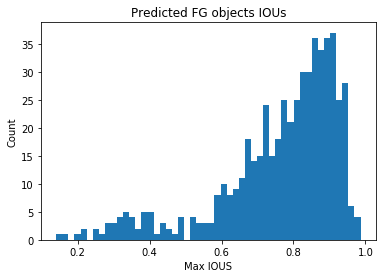

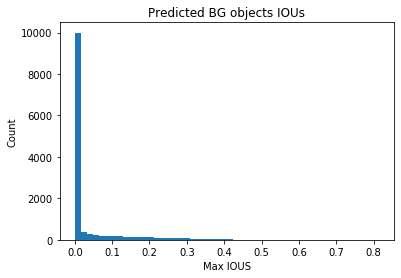

FPs: 142
FNs: 2407
TPs: 408
TNs: 10667

Total FG detections: 550
Total BG detections: 13074

FP/TP+FP: 25.818182%
FN/TN+FN: 18.410586%


In [12]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")

if False:
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### Kitti Val

In [30]:
%reset -f array

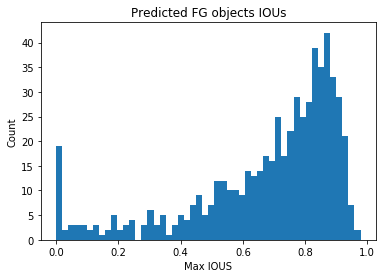

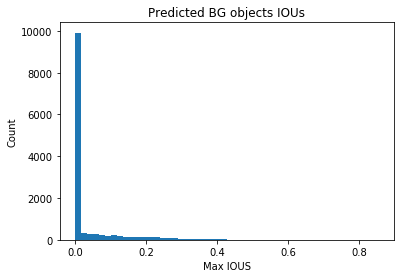

FPs: 240
FNs: 2724
TPs: 351
TNs: 10292

Total FG detections: 591
Total BG detections: 13016

FP/TP+FP: 40.609137%
FN/TN+FN: 20.928089%


In [13]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

if False:
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### IDD Val

In [32]:
%reset -f array

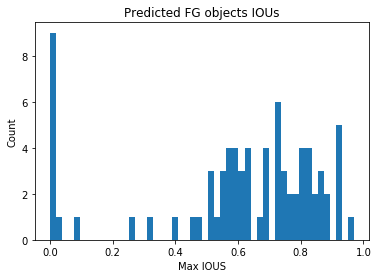

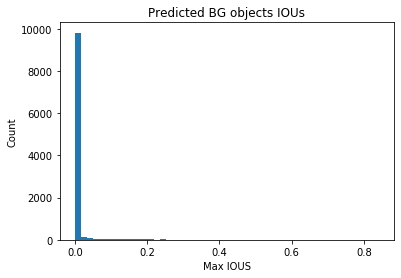

FPs: 43
FNs: 1151
TPs: 34
TNs: 9278

Total FG detections: 77
Total BG detections: 10429

FP/TP+FP: 55.844156%
FN/TN+FN: 11.036533%


In [14]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

if False:
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

# Max Softmax

#### Kitti val

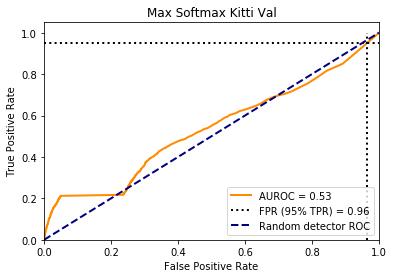

{'fpr_at_95_tpr': 0.96470000710438, 'detection_error': 0.5, 'auroc': 0.5324374983235487, 'aupr_in': 0.30822249861863704, 'aupr_out': 0.7898913923559602}


In [15]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_scores(save_path)

kitti_val_novelty_scores = -kitti_val_X
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="Max Softmax Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD val

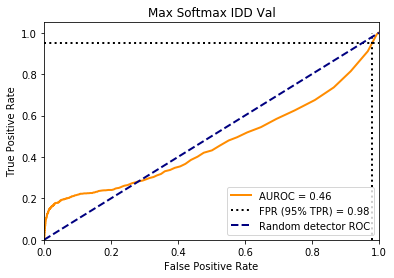

{'fpr_at_95_tpr': 0.9798351625671343, 'detection_error': 0.5, 'auroc': 0.46447248978319833, 'aupr_in': 0.20557711313757832, 'aupr_out': 0.8637634600762778}


In [16]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_scores(save_path)

idd_val_novelty_scores = -idd_val_X
plot_roc(idd_val_novelty_scores, idd_val_y, title="Max Softmax IDD Val")
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

## One-Class SVM on Kitti features (Conv-512 layer)

In [11]:
%reset -f array

In [39]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-conv-512-one-class.pickle")
    
if False:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
    kitti_train_X, kitti_train_y = read_features(save_path, 0)
    print(kitti_train_X.shape)
    
    training_mask = np.logical_not(kitti_train_y.astype(np.bool))

    print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)

    clf = svm.OneClassSVM(nu=0.001, kernel="rbf")

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])
    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

#### Kitti Val

In [40]:
%reset -f array

In [41]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_features, [save_path, 0], save_path, clf.decision_function, 1000)

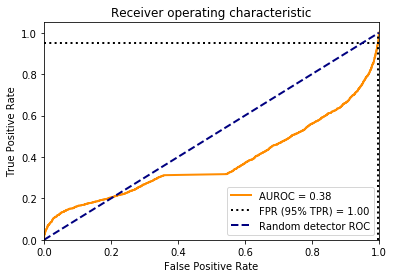

{'fpr_at_95_tpr': 0.9973766031869413, 'detection_error': 0.5, 'auroc': 0.3783653870847894, 'aupr_in': 0.24180354936185483, 'aupr_out': 0.697267163327909}


In [42]:
plot_roc(-kitti_val_novelty_scores, kitti_val_y)
print(calc_metrics(-kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [43]:
%reset -f array

In [44]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_features, [save_path, 0], save_path, clf.decision_function, 1000)

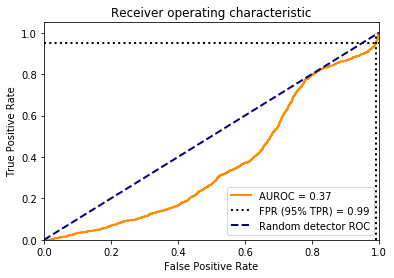

{'fpr_at_95_tpr': 0.9911618883380039, 'detection_error': 0.49973054537615863, 'auroc': 0.3706732048703537, 'aupr_in': 0.08030874117092246, 'aupr_out': 0.8534100613070854}


In [45]:
plot_roc(-idd_val_novelty_scores, idd_val_y)
print(calc_metrics(-idd_val_novelty_scores, idd_val_y))

## One-Class SVM on Kitti features (FC-4096 (#1) layer) 

In [46]:
%reset -f array

In [47]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-fc-4096-1-one-class.pickle")
    
if True:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
    kitti_train_X, kitti_train_y = read_features(save_path, 1)
    print(kitti_train_X.shape)
    
    training_mask = kitti_train_y.astype(np.bool)
    print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)
    
    clf = svm.OneClassSVM(nu=0.001, kernel="rbf")

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])

    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)


(13074, 4096)
Collected 2407 train samples of size 4096


/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


8


#### Kitti Val

In [48]:
%reset -f array

In [49]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_features, [save_path, 1], save_path, clf.decision_function, 1000)

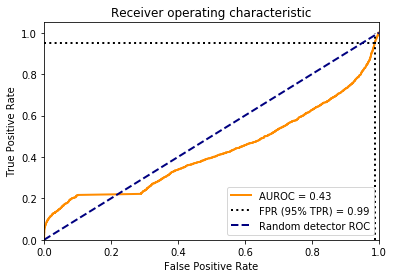

{'fpr_at_95_tpr': 0.9873688301593471, 'detection_error': 0.4997949022179381, 'auroc': 0.42536113617465454, 'aupr_in': 0.2839463053579994, 'aupr_out': 0.7242675581317557}


In [50]:
plot_roc(-kitti_val_novelty_scores, kitti_val_y)
print(calc_metrics(-kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [51]:
%reset -f array

In [52]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_features, [save_path, 1], save_path, clf.decision_function, 1000)

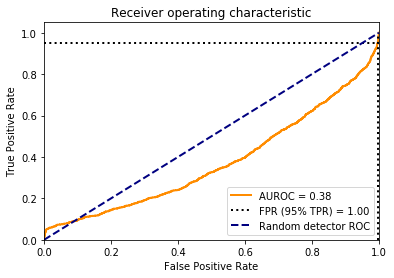

{'fpr_at_95_tpr': 0.9961198534166846, 'detection_error': 0.5, 'auroc': 0.375237499318755, 'aupr_in': 0.11595834568239499, 'aupr_out': 0.8338747942232282}


In [53]:
plot_roc(-idd_val_novelty_scores, idd_val_y)
print(calc_metrics(-idd_val_novelty_scores, idd_val_y))

# Mahalanobis

In [54]:
%reset -f array

In [55]:
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis.h5")

if True:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
    kitti_train_X, kitti_train_y = read_features(save_path, 4)
    print(kitti_train_X.shape)
    
    # Take features from good detections only
    kitti_mahalanobis_features = kitti_train_X[np.logical_not(kitti_train_y.astype(np.bool))]
    
    # Everything is labelled 0 because we're just doing single class detection
    kitti_mahalanobis_labels = np.zeros((len(kitti_mahalanobis_features)))
    
    md = Mahal_Dist(kitti_mahalanobis_features, kitti_mahalanobis_labels)
    md.save(mahal_model_name)
    
else:
    md = Mahal_Dist.load(mahal_model_name)


(13074, 4096)
Calculating mahal mean
Calculating mahal cov
Inverting


#### Kitti val

In [56]:
%reset -f array

In [57]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_features, [save_path, 4], save_path, md, 1000)

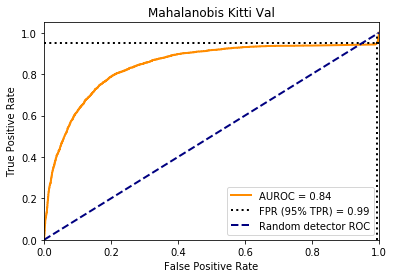

{'fpr_at_95_tpr': 0.994073066459386, 'detection_error': 0.5, 'auroc': 0.84207745433917, 'aupr_in': 0.6459077068355695, 'aupr_out': 0.8832660874398857}


In [58]:
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="Mahalanobis Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD val

In [59]:
%reset -f array

In [60]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_features, [save_path, 4], save_path, md, 1000)

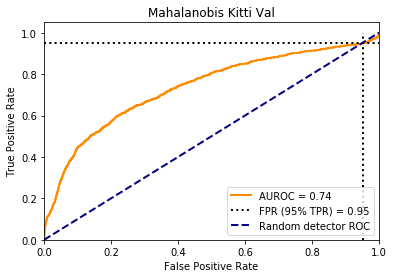

{'fpr_at_95_tpr': 0.9514981677085579, 'detection_error': 0.5, 'auroc': 0.7350463686693613, 'aupr_in': 0.3305848921140345, 'aupr_out': 0.9344153916853183}


In [61]:
plot_roc(idd_val_novelty_scores, idd_val_y, title="Mahalanobis Kitti Val")
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

## ODIN

### Find best params

In [62]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.

# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
temperatures = np.array([1000])
epsilons = np.linspace(0, 0.004, 21)
odin_params = list(itertools.product(epsilons, temperatures))

In [63]:
results = []

trainer.faster_rcnn.eval()
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    save_file = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

    if False:
        extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

    print("ODIN Kitti Val e=%f, T=%d" % (eps, temp))
    kitti_val_X, kitti_val_y = read_scores(save_file, leave=False)
    kitti_val_novelty_scores = -kitti_val_X
    results.append(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)



ODIN Kitti Val e=0.000000, T=1000


/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:664: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd



ODIN Kitti Val e=0.000200, T=1000


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()


  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaco

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<ipython-input-63-d12e08dde4ae>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
 

  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    se


ODIN Kitti Val e=0.000400, T=1000



ODIN Kitti Val e=0.000600, T=1000


--- Logging error ---
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__in

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 132, in _run_after_forke

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 381, in preinit
    from . import BmpImagePlugin
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/BmpImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootst


ODIN Kitti Val e=0.000800, T=1000



ODIN Kitti Val e=0.001000, T=1000


--- Logging error ---
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__in

Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
BrokenPipeErro

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/py

  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "<ipython-input-63-d12e08dde4ae>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", li

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563,

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.par

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShe

  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<frozen i

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GifImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette, ImageChops, ImageSequence
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GifImagePlugin.py", line 498, in <module>
    def _save(im, fp, filename, save_all=False):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/sre_parse.py", line 166, in __getitem__
    return SubPattern(self.pattern, self.data[index])
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/s


ODIN Kitti Val e=0.001200, T=1000


--- Logging error ---
--- Logging error ---


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.fl

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in

Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-pac

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "<ipython-input-63-d12e08dde4ae>", line 8, in <module>
    extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/po

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  F

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", li

  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "<frozen importlib._bootstrap>", line 9

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    ob

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'f3db980b-c67d7bc28e94aef377565a99', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 26, 13, 483448, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': 'f3db980b-c67d7bc28e94aef377565a99', 'msg_type

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'fbb42009-


ODIN Kitti Val e=0.001400, T=1000



ODIN Kitti Val e=0.001600, T=1000



ODIN Kitti Val e=0.001800, T=1000



ODIN Kitti Val e=0.002000, T=1000



ODIN Kitti Val e=0.002200, T=1000



ODIN Kitti Val e=0.002400, T=1000



ODIN Kitti Val e=0.002600, T=1000



ODIN Kitti Val e=0.002800, T=1000


--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__

--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
--- Logging error ---
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, r

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/reduction.py", line 194, in DupFd
    return resource_sharer.DupFd(fd)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/resource_sharer.py", line 53, in __init__
    self._id = _resource_sharer.register(send, close)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    s

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'ad6476e4-96be034aea83f8e65d33bf78', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 26, 58, 866274, tzinfo=dat

  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumera

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fe

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/xml/etree/ElementTree.py", line 1197, in parse
    tree.parse(source, parser)
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/xml/etree/ElementTree.py", line 598, in parse
    self._root = parser._parse_whole(source)
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, 

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", lin


ODIN Kitti Val e=0.003000, T=1000


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-pac

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipy

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/p

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/weakref.py", line 217, in items
    yield k, v
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/h

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 128, in _run_after_forkers
    items = list(_afterfork_registry.items())
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/weakref.py", line 217, in items
    yield k, v
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  Fi

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forker


ODIN Kitti Val e=0.003200, T=1000



ODIN Kitti Val e=0.003400, T=1000



ODIN Kitti Val e=0.003600, T=1000



ODIN Kitti Val e=0.003800, T=1000



ODIN Kitti Val e=0.004000, T=1000


In [64]:
best_params = np.argmin([x['fpr_at_95_tpr'] for x in results[1:]])
print("Best params:", odin_params[1:][best_params])

eps, temp = odin_params[1:][best_params]

Best params: (0.0024000000000000002, 1000)


### Calc results for data using found params

#### Kitti val


ODIN Kitti Val e=0.002400, T=1000


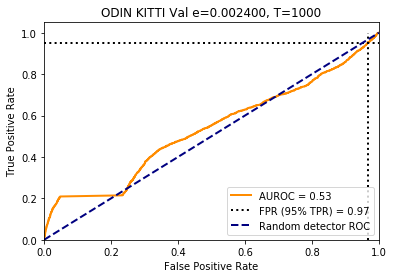

{'fpr_at_95_tpr': 0.9665662357857906, 'detection_error': 0.49896271158028394, 'auroc': 0.5322705730980177, 'aupr_in': 0.3101577141391455, 'aupr_out': 0.7886621846072395}


In [65]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

if False:
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path, eps, temp)

print("ODIN Kitti Val e=%f, T=%d" % (eps, temp))

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_scores, [save_path], save_path, lambda x: -x, 1000)

plot_roc(kitti_val_novelty_scores, kitti_val_y, title="ODIN KITTI Val e=%f, T=%d" %(eps, temp))
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD val

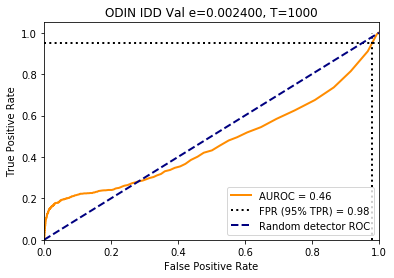

{'fpr_at_95_tpr': 0.9798351625671343, 'detection_error': 0.5, 'auroc': 0.46447248978319833, 'aupr_in': 0.20557711313757832, 'aupr_out': 0.8637634600762778}


In [66]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

if True:
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path, eps, temp)

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_scores, [save_path], save_path, lambda x: -x, 1000)

plot_roc(idd_val_novelty_scores, idd_val_y, title="ODIN IDD Val e=%f, T=%d" %(eps, temp))
print(calc_metrics(idd_val_novelty_scores,  idd_val_y))

## Entropy

In [14]:
import mc_uncertainty as mcu
from model.utils.bbox_tools import loc2bbox, bbox2loc, bbox_iou
from torch.nn import functional as F

def _predict_mc(self, imgs, sizes=None, visualize=False, num_passes=1):
    if visualize:
        self.use_preset('visualize')
        prepared_imgs = list()
        sizes = list()
        for img in imgs:
            size = img.shape[1:]
            img = preprocess(at.tonumpy(img))
            prepared_imgs.append(img)
            sizes.append(size)
    else:
         prepared_imgs = imgs 
    bboxes = list()
    labels = list()
    scores = list()
    all_mc_scores = list()

    for img, size in zip(prepared_imgs, sizes):
        scale = img.shape[2] / size[1]

        img = at.totensor(img[None], cuda=True).float()

        h = self.extractor(img)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.rpn(h, img.shape[2:], scale)
        roi_cls_locs, roi_scores = self.head(h, rois, roi_indices)
        
        self.train()
        mc_scores = [self.head(h, rois, roi_indices)[1] for _ in range(num_passes)]
        self.eval()
        
        # We are assuming that batch size is 1.
        roi_scores = roi_scores.data
        mc_scores = [s.data for s in mc_scores]
        roi_cls_loc = roi_cls_locs.data
        roi = at.totensor(rois) / scale

        # Convert predictions to bounding boxes in image coordinates.
        # Bounding boxes are scaled to the scale of the input images.
        mean = t.Tensor(self.loc_normalize_mean).cuda(). \
            repeat(self.n_class)[None]
        std = t.Tensor(self.loc_normalize_std).cuda(). \
            repeat(self.n_class)[None]

        roi_cls_loc = (roi_cls_loc * std + mean)
        roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
        roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
        cls_bbox = loc2bbox(at.tonumpy(roi).reshape((-1, 4)),
                            at.tonumpy(roi_cls_loc).reshape((-1, 4)))
        cls_bbox = at.totensor(cls_bbox)
        cls_bbox = cls_bbox.view(-1, self.n_class * 4)
        # clip bounding box
        cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[0])
        cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[1])

        prob = at.tonumpy(F.softmax(at.totensor(roi_scores), dim=1))
        mc_scores = [at.tonumpy(F.softmax(at.totensor(s), dim=1)) for s in mc_scores]

        raw_cls_bbox = at.tonumpy(cls_bbox)
        raw_prob = at.tonumpy(prob)

        bbox, label, score, mc_scores = self._suppress_with_features(raw_cls_bbox, raw_prob, mc_scores)

        bboxes.append(bbox)
        labels.append(label)
        scores.append(score)
        all_mc_scores.append(mc_scores)

    # self.use_preset('evaluate')

    return bboxes, labels, scores, all_mc_scores

trainer.faster_rcnn.predict_mc = _predict_mc.__get__(trainer.faster_rcnn)

In [19]:
import mc_uncertainty as mcu

NUM_MC_PASSES = 10


def _extract_mc_softmax(dset_type, dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, res in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            if dset_type == "kitti":
                imgs, sizes, gt_bboxes, gt_labels, _ = res
            elif dset_type == "idd":
                imgs, gt_bboxes, gt_labels = res

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_mc(imgs, visualize=True, num_passes=NUM_MC_PASSES)
            pred_bboxes, pred_labels, pred_scores, mc_scores = res
            pred_bboxes, pred_labels, pred_scores, mc_scores = pred_bboxes[0], pred_labels[0], pred_scores[0], mc_scores[0]

            if len(gt_labels) > 0:
                ious = bbox_iou(pred_bboxes, np.array(gt_bboxes))
                max_ious = np.nan_to_num(ious.max(axis=1))
                max_aligned_gt_label = ious.argmax(axis=1)
                
                true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            else:
                max_ious = [0] * len(pred_labels)
                true_label_per_pred = [-1] * len(max_ious)
            
            true_label_per_pred[max_ious==0] = -1  # Assign BG true labels
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 
            d.create_dataset("mc_scores", data=mc_scores)  

            
def extract_kitti_mc_softmax(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    _extract_mc_softmax("kitti", dataset, model, save_file)
        
        
def extract_idd_mc_softmax(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    _extract_mc_softmax("idd", dataset, model, save_file)


def read_mc_scores(save_file, start=0, end=None, leave=True):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    
    Label array is 1 for a true negative and 0 for a false negative
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
        
        for i in trange(start, end, leave=leave):
            d = f[str(i)]
            features = d["mc_scores"][()]
            
            # Select only the negative preds
            label_is_fg = d["pred_labels"][()] >= 0
            mask = np.logical_not(label_is_fg)
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features[:,mask])
            else:
                X = np.concatenate((X, features[:,mask]), axis=1)
            
            iou_is_low_enough = d["pred_max_ious"][()][mask] < MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()][mask] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = iou_is_low_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, 1 - y

#### Kitti Val

In [20]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")

if False:
    extract_kitti_mc_softmax(kitti_val_dataset, trainer.faster_rcnn, save_path)

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_mc_scores, [save_path], save_path, mcu.predicted_entropy, 1000)

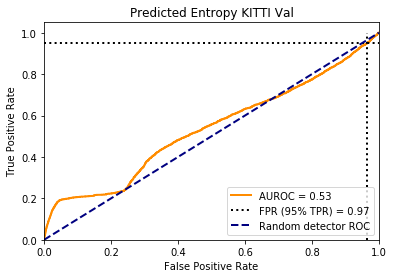

{'fpr_at_95_tpr': 0.9655071900505247, 'detection_error': 0.49965465100418727, 'auroc': 0.5346597773786634, 'aupr_in': 0.3057004575025338, 'aupr_out': 0.7914203090733919}


In [21]:
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="Predicted Entropy KITTI Val")
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [22]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")

if False:
    extract_idd_mc_softmax(idd_val_dataset, trainer.faster_rcnn, save_path)

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_mc_scores, [save_path], save_path, mcu.predicted_entropy, 1000)

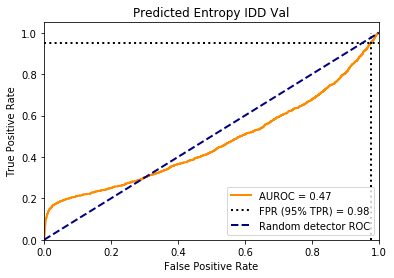

{'fpr_at_95_tpr': 0.9758568657038155, 'detection_error': 0.4996227635266221, 'auroc': 0.46895236604102003, 'aupr_in': 0.20658351139653747, 'aupr_out': 0.8667635474198678}


In [23]:
plot_roc(idd_val_novelty_scores, idd_val_y, title="Predicted Entropy IDD Val")
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

## Mutual Information

#### Kitti Val

In [25]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_mc_scores, [save_path], save_path, mcu.mutual_information, 1000)

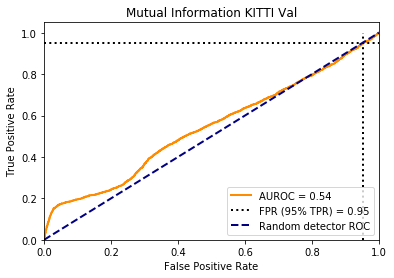

{'fpr_at_95_tpr': 0.954041974349009, 'detection_error': 0.5, 'auroc': 0.5421881679053859, 'aupr_in': 0.3024814214427831, 'aupr_out': 0.7981644221360568}


In [26]:
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="Mutual Information KITTI Val")
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [27]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_mc_scores, [save_path], save_path, mcu.mutual_information, 1000)

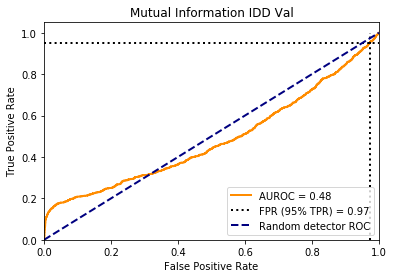

{'fpr_at_95_tpr': 0.9721922828195732, 'detection_error': 0.4998922181504635, 'auroc': 0.48335856670928623, 'aupr_in': 0.2072945621233671, 'aupr_out': 0.8734527188852077}


In [28]:
plot_roc(idd_val_novelty_scores, idd_val_y, title="Mutual Information IDD Val")
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

# Vahdats Extended Feature Extractor Set

### Bind a feature extractor function to the model

In [11]:
model = trainer.faster_rcnn

@nograd
def get_all_features(self, imgs, visualize=False):
    self.eval()
    if visualize:
        prepared_imgs = list()
        for img in imgs:
            img = preprocess(at.tonumpy(img))
            prepared_imgs.append(img)
    else:
         prepared_imgs = imgs 

    for img in prepared_imgs:
        img = at.totensor(img[None], cuda=True).float()
        features = [img]
        
        for l in self.extractor:
            features.append(l(features[-1]))
        
        # Detach all features from GPU
        features = [at.tonumpy(f) for f in features]
        # Remove the first feature (ie the image)
        features = features[1:]
        # Average the features over the final two dimensions
        features = [np.mean(f, axis=(2,3)).squeeze(axis=0) for f in features]
        return features
    
model.get_all_features = get_all_features.__get__(model)

### Get the GT features

In [12]:
def extract_extended_kitti_features_gt(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)
            
            cars_bboxes = gt_bboxes[gt_labels == 0]
            
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(cars_bboxes):
                d_car = d.create_group("gt_bbox_"+str(j))
                y1, x1, y2, x2 = box.type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]
                
                # Check correct sections of image are extracted
                # plt.imshow(np.moveaxis(np.squeeze(at.tonumpy(im), axis=0), 0, 2).astype(np.int))
                # plt.show()
                
                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                
                for k, feats in enumerate(features):
                    d_car.create_dataset("extended_feat_"+str(k), data=feats)
%reset -f array
if False:
    extract_extended_kitti_features_gt(kitti_train_dataset, trainer.faster_rcnn, os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5"))

In [13]:
def _extract_extended_features(dset_type, dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, res in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            if dset_type == "kitti":
                imgs, sizes, gt_bboxes, gt_labels, _ = res
            elif dset_type == "idd":
                imgs, gt_bboxes, gt_labels = res

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)
            
            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]
        
            if len(gt_labels) > 0:
                ious = bbox_iou(pred_bboxes, np.array(gt_bboxes))
                max_ious = np.nan_to_num(ious.max(axis=1))
                max_aligned_gt_label = ious.argmax(axis=1)
                
                true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            else:
                max_ious = [0] * len(pred_labels)
                true_label_per_pred = [-1] * len(max_ious)
            
            true_label_per_pred[max_ious==0] = -1  # Assign BG true labels
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            preds = d.create_group('pred')
            preds.create_dataset("pred_boxes", data=pred_bboxes)
            preds.create_dataset("pred_scores", data=pred_scores)
            preds.create_dataset("pred_labels", data=pred_labels)
            preds.create_dataset("pred_num_detections", data=len(pred_bboxes))
            preds.create_dataset("pred_max_ious", data=max_ious) 
            preds.create_dataset("pred_label_correct", data=pred_label_correct)

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                
            bboxes = d.create_group('bboxes')
            # Get the extended feature set from the cropped bbox sections
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(at.totensor(pred_bboxes)):
                d_box = bboxes.create_group(str(j))
                y1, x1, y2, x2 = box.round().type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]

                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                
                for k, feats in enumerate(features):
                    d_box.create_dataset("extended_feat_"+str(k), data=feats)

def extract_extended_kitti_features(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    _extract_extended_features("kitti", dataset, model, save_file)
                    
                    
def extract_extended_idd_features(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    _extract_extended_features("idd", dataset, model, save_file)

%reset -f array
if False:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
    extract_extended_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

%reset -f array
if False:
    save_path = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_extended.hdf5")
    extract_extended_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_path)

%reset -f array
if False:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
    extract_extended_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

%reset -f array
if False:
    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
    extract_extended_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path)

### Train SVM classifiers

In [14]:
# Train a one-class SVM networks with those features
GT_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5")
SUBSET_KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_extended.hdf5")
KITTI_TRAIN_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
IDD_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
NUM_EXTENDED_FEATURES = 30

def read_gt_extended_features(file, feature_idx):
    features = None
    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]
            
            for gt_bbox in im.keys():
                gt_bbox = im[gt_bbox]
                feats = gt_bbox["extended_feat_%d" % feature_idx]

                if features is None:
                    features = np.expand_dims(feats, axis=0)
                else:
                    features = np.concatenate((features, np.expand_dims(feats, axis=0)), axis=0)
    
    return features


# Train all the classifiers
def train_osvm(nu, gamma, kernel, train_features, one_class_save_path):
        # Train one class SVM
        clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
        clf.fit(train_features)

        # Save classifier
        with open(one_class_save_path, 'wb') as f:
            pickle.dump(clf, f)

In [15]:
def read_extended_features(file, feature_idx):
    X = None
    y = np.empty((0,))

    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]            
            
            # Select only the negative preds
            label_is_fg = im['pred']["pred_labels"][()] >= 0
            mask = np.logical_not(label_is_fg)
            
            iou_is_low_enough = im['pred']["pred_max_ious"][()][mask] < MIN_IOU_REQUIRED
            classification_is_correct = im['pred']["pred_label_correct"][()][mask] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = iou_is_low_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)

            # Get the required features
            for j in np.array(sorted(im['bboxes'].keys()))[mask]:
                bbox = im['bboxes'][j]
                feats = bbox["extended_feat_%d" % feature_idx]

                if X is None:
                    X = np.expand_dims(feats, axis=0)
                else:
                    X = np.concatenate((X, np.expand_dims(feats, axis=0)), axis=0)
    
    return X, 1 - y

In [16]:
NUS = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
# GAMMAS = ['auto', 'scale']
GAMMAS = ['auto']
# KERNELS = ['rbf', 'linear']
KERNELS = ['rbf']

train_args = list(itertools.product(NUS, GAMMAS, KERNELS))

if False:
    for i in trange(NUM_EXTENDED_FEATURES):
        features, labels = read_extended_features(KITTI_TRAIN_FEATURES_FILE, i)
        
        # Use only the good BG guesses on the train set
        features = features[labels == 0]
            
        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            train_osvm(nu, gamma, kernel, features, save_path)

### Determine best params/OODL

In [17]:
if False:
    kitti_val_results = []

    for i in trange(NUM_EXTENDED_FEATURES):

        # Load the kitti val features
        kitti_val_X, kitti_val_y = read_extended_features(SUBSET_KITTI_VAL_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            # Load the classifier
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            with open(save_path, 'rb') as f:
                clf = pickle.load(f)

            # Calculate performance metrics
            kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
            res = calc_metrics(kitti_val_novelty_scores, kitti_val_y.astype(np.int))

            res['nu'] = nu
            res['gamma'] = gamma
            res['kernel'] = kernel
            res['features'] = i
            res['model'] = save_path

            kitti_val_results.append(res)

    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/subset_kitti_val_results.pickle'), 'wb') as f:
        pickle.dump(kitti_val_results, f)

else:
    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/subset_kitti_val_results.pickle'), 'rb') as f:
        kitti_val_results = pickle.load(f)

In [18]:
best_params = np.argmin([k['detection_error'] for k in kitti_val_results])

print(best_params)
print(kitti_val_results[best_params])

184
{'fpr_at_95_tpr': 0.8717948717948718, 'detection_error': 0.45940170940170943, 'auroc': 0.6090839360070129, 'aupr_in': 0.25282109472849545, 'aupr_out': 0.8570326040621117, 'nu': 0.0001, 'gamma': 'auto', 'kernel': 'rbf', 'features': 23, 'model': './idd_fn_detection/one_class_models/kitti-one-class-extended-feat23-nu0.0001-gammaauto-kernelrbf.pickle'}


In [19]:
oodl, (nu, gamma, kernel) = list(itertools.product(list(range(NUM_EXTENDED_FEATURES)), train_args))[best_params]
print(oodl, nu, gamma, kernel)

23 0.0001 auto rbf


In [20]:
# Load the best classifier
save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (oodl, nu, gamma, kernel))
with open(save_path, 'rb') as f:
    clf = pickle.load(f)

### Kitti Val

In [21]:
%reset -f array

In [22]:
kitti_val_X, kitti_val_y = read_extended_features(KITTI_VAL_FEATURES_FILE, oodl)

# Calculate performance metrics
kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
res = calc_metrics(kitti_val_novelty_scores, kitti_val_y.astype(np.int))

res['nu'] = nu
res['gamma'] = gamma
res['kernel'] = kernel
res['features'] = oodl
res['model'] = save_path

print(res)

{'fpr_at_95_tpr': 0.9323746599300428, 'detection_error': 0.4911506192454913, 'auroc': 0.566785937269042, 'aupr_in': 0.25063825537667034, 'aupr_out': 0.8202487663140954, 'nu': 0.0001, 'gamma': 'auto', 'kernel': 'rbf', 'features': 23, 'model': './idd_fn_detection/one_class_models/kitti-one-class-extended-feat23-nu0.0001-gammaauto-kernelrbf.pickle'}


In [25]:
print(res)

{'fpr_at_95_tpr': 0.9323746599300428, 'detection_error': 0.4911506192454913, 'auroc': 0.566785937269042, 'aupr_in': 0.25063825537667034, 'aupr_out': 0.8202487663140954, 'nu': 0.0001, 'gamma': 'auto', 'kernel': 'rbf', 'features': 23, 'model': './idd_fn_detection/one_class_models/kitti-one-class-extended-feat23-nu0.0001-gammaauto-kernelrbf.pickle'}


### IDD VAL

In [30]:
%reset -f array

In [36]:
idd_val_X, idd_val_y = read_extended_features(IDD_VAL_FEATURES_FILE, oodl)

In [41]:
# Calculate performance metrics
idd_val_novelty_scores = clf.decision_function(idd_val_X)

res = calc_metrics(idd_val_novelty_scores, idd_val_y.astype(np.int))

res['nu'] = nu
res['gamma'] = gamma
res['kernel'] = kernel
res['features'] = oodl
res['model'] = save_path

print(res)

{'fpr_at_95_tpr': 0.8977150247898253, 'detection_error': 0.4724198795053235, 'auroc': 0.5504445275568505, 'aupr_in': 0.12557066845669232, 'aupr_out': 0.9105850491054801, 'nu': 0.0001, 'gamma': 'auto', 'kernel': 'rbf', 'features': 23, 'model': './idd_fn_detection/one_class_models/kitti-one-class-extended-feat23-nu0.0001-gammaauto-kernelrbf.pickle'}


## Mahalanobis with input perturbation

In [67]:
%reset -f array

In [68]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.

# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
temperatures = np.array([1000])

epsilons = np.linspace(0, 0.004, 21)
# epsilons = np.array([0.0034])

odin_params = list(itertools.product(epsilons, temperatures))

Build a Mahalanobis model for each of train eps and temp

In [69]:
if False:
    for eps, temp in tqdm(odin_params, total=len(odin_params)):
        save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_pert_%f_temp_%d.hdf5" % (eps, temp))
        
        if False:
            extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
        
        kitti_train_X, kitti_train_y = read_features(save_file, 4)

        mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
    
        # Take features from good detections only
        kitti_mahalanobis_features = kitti_train_X[np.logical_not(kitti_train_y.astype(np.bool))]

        # Everything is labelled 0 because we're just doing single class detection
        kitti_mahalanobis_labels = np.zeros((len(kitti_mahalanobis_features)))

        md = Mahal_Dist(kitti_mahalanobis_features, kitti_mahalanobis_labels)
        md.save(mahal_model_name)


Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.p

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kit

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    us

--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupy

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 127, in get_example
    os.path.join(self.data_dir, 'Annotations', id_ + '.xml'))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/xml/etree/ElementTree.py", line 1197, in parse
    tree.parse(source, parser


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/p

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py"

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "<

  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/pytho

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 132, in _run_after_forkers
    func(obj)
  File "/home/tadenoud/anaco

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._boots

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 387, in preinit
    from . import 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap_external>", line 1252, in _get_spec
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GifImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette, 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in displ

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'cffda2a3-277c86442a8586d6508c3353', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 35, 0, 140666, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': 'cffda2a3-277c86442a8586d6508c3353', 'msg_type': 'comm_msg', 'paren


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
--- Logging error ---
--- Logging error ---
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
--- Logging error ---
Traceback (mos

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()


  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/ta

  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File

  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/py

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadeno

  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/BmpImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '97146a55-f00de71e68fee2e6dd3f9ee2', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datet


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/

BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.p

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipyke

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/py

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/cor

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "<frozen importlib._boots

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<ipython-input-10-11ae0442

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/BmpImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self.

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176,

  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '36934fa9-3a2d25e551f4aafd2b74488a', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 37, 11, 662828, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '36934fa9-3a2d25e551f4aafd2b74488a', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': '499d838c60e74a5d801c86cc8b2e9eb9', 'username': 'username', 'session': '395bcf50e18d403e8816ee24b63e03e9', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2020, 1, 7, 3, 31, 16, 418645, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 146/146 [00:05&lt;00:00, 25.65it/s]'}, 'buffer_paths': []}, 'comm_id': 'ad6bd6915f04466b97b71bb12cb14084'}, 'metadata': {}}
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-pac


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
BrokenPipeError: 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/conf

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/async

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, s

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 387, in preinit
    from . import GifImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 381, in preinit
    from . import BmpImagePlugin
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<fr

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '090a64d0-2ef9497d9f22d7cd15abe9b6', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
--- Logging error ---
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
--- Logging error ---
Traceback (most recent call last):
 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipyk

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 305

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_fe

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/ta

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/I

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/BmpImagePlugin.py", line 27, in <module>
    from . import Image, ImageFil

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'fa3a7113-f0a2546e564056b090593a2e', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 39, 21, 594266, tzinfo=datetime.timezone.utc), 'version': 


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
--- Logging error ---


Traceback (most recent call last):
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anacond

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/e

  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    d

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-pac

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '4cdb2454-625e2fb6b986423a3e46598b', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 40, 27, 510634, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '4cdb2454-625e2fb6b986423a3e46598b', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': '499d838c60e74a5d801c86cc8b2e9eb9', 'username': 'username', 'session': '395bcf50e18d403e8816ee24b63e03e9', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2020, 1, 7, 3, 31, 16, 418645, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
Traceback (most recent call last):
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File

--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupy


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactives

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kit

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  Fi

  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
   

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': 'e24a5330-c161859dd218f41730ad79cd', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 41, 31, 429704, tzinfo=datetime.timezone.utc


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", li

Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anac

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.p

  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/py

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._laun

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "

  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstr

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap_external>", line 828, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py"

  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap_external>", line 1280, in find_spec
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anacon

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/li


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):


BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/sit

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaco

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  

  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturb

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", data

  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/pyt

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GifImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette, ImageChops, ImageSequence
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen i

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen import

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 381, in preinit
    from . import BmpImagePlugin
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebo

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/t


Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):


--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(c

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in 

  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    

  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<frozen importlib._bootstrap_external>", 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 387, in preinit
    from . import GifImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '2309e1b1-016d75bc6c455c45688db0d5', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 45, 51, 931347, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '2309e1b1-016d75bc6c455c45688db0d5', 'msg_type': 'comm_msg', 'parent_head

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/TiffImagePlugin.py", line 146, in <module>
    COMPRESSION_INFO_REV = {v: k for k, v in COMPRESSION_IN

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '071faff1-ff97f816c8066a230fbc3623', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 45, 51, 931129, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '071faff1-ff97f816c8066a230fbc3623', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': '499d838c60e74a5d801c86cc8b2e9eb9', 'username': 'username', 'session': '395bcf50e18d403e8816ee24b63e03e9', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.dat


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
--- Logging error ---
--- Logging error ---
Call stack:
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", li

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  F

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    l

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "<ipython-input-69-a667315b7e97>", line 6, in <module>
    extract_kitti_features(kitti_train_dataset,trainer.faster_rcnn,save_file,perturbation=eps,temperature=temp)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, *

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/en

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/li

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/hom

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GifImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette, ImageChops, ImageSequence
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap_external>", line 525, in _compi

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/py


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launch

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 132, in _run_after_forkers
    func(obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/queues.py", line 69, in _after_fork
    self._notempty = threading.Condition(threading.Lock())
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py"

  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-package


Calculating mahal mean
Calculating mahal cov
Inverting



Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", lin

BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mo

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
  

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/intera

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = 

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 387, in preinit
    from . import GifImagePlugin
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._boots

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/wi

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_

  File "<frozen importlib._bootstrap_external>", line 857, in get_code
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '343e047a-8d1629a4e87939246455011d', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 50, 12, 196013, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '343e047a-8d1629a4e87939246455011d', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': '499d838c60e74a5d801c86cc8b2e9eb9', 'username': 'username', 'session': '395bcf50e18d403e8816ee24b63e03e9', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2020, 1, 7, 3, 31, 16, 418645, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 146/146 [00:05&lt;00:00, 28.86it/s]'}, 'buffer_paths': []}, 'comm_id': 'deb6b619eb2a4f8da6bb829a6910590c'}, 'metadata': {}}
  File "<frozen importlib._bootstrap_external>", line 525, in _com


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/en

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = s

  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IP

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packag

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 256, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "<ipython-input-10-11ae04424995>", line 9, in _extract_features
    for i, res in tqdm(enumerate(dataloader), total=len(dataloader)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/ImageChops.py", line 142, in <module>
    def add(image1, image2, scale=1.0, offset=0):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 278, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen importlib._bootstrap_external>", line 72

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "<frozen importlib._bootstrap_external

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/BmpImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 249, in close
    self.sp(bar_style='success')
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
  


Calculating mahal mean
Calculating mahal cov
Inverting


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()


  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/t

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tor

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "<ipython-input-10-11ae04424995>", line 57, in extract_kitti_features
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anacon

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykerne

  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py", line 169, in get_example
    img = read_image(img_file, color=True)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 682, in __init__
    w.start()
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/util.py", line 26, in read_image
    f = Image.open(path)
  File "/home/tad

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 393, in preinit
    from . import JpegImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<f

  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/notebook.py", line 176, in display
    ptext.value = right
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>",

  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/GifImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette, ImageChops, ImageSequence
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.close()
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstr

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '80baa992-a5ae80c7e7581c2c81180512', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '1bc7733b-767ae1b3477feaad1e3f7a37', 'date': datetime.datetime(2020, 1, 7, 3, 52, 22, 151343, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '80baa992-a5ae80c7e7581c2c81180512', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': '499d838c60e74a5d801c86cc8b2e9eb9', 'username': 'username', 'session': '395bcf50e18d403e8816ee24b63e03e9', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2020, 1, 7, 3, 31, 16, 418645, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'update', 'state': {'value': ' 146/146 [00:05&lt;00:00, 26.49it/s]'}, 'buffer_paths': []}, 'comm_id': 'c5558d4013334fe0ab4d4eeb


Calculating mahal mean
Calculating mahal cov
Inverting



Get the best model based on the Kitti Val performance

In [70]:
%reset -f array

In [71]:
results2 = []
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    # Get the data
    save_path = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
    kitti_val_X, kitti_val_y = read_features(save_path, 4)
    
    # Load the model
    mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
    md = Mahal_Dist.load(mahal_model_name)
    
    kitti_val_novelty_scores = md(kitti_val_X)
    results2.append(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

In [72]:
# Pick the best eps and temp

idx = np.argmin(x['fpr_at_95_tpr'] for x in results2[1:])
eps, temp = odin_params[1:][idx]
print("e:", eps, "T:", temp)

# Load the model
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
md = Mahal_Dist.load(mahal_model_name)

e: 0.0002 T: 1000


#### Kitti val

In [73]:
%reset -f array

In [74]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

kitti_val_novelty_scores, kitti_val_y = chunked_calc(
    read_features, [save_path, 4], save_path, md, 1000)

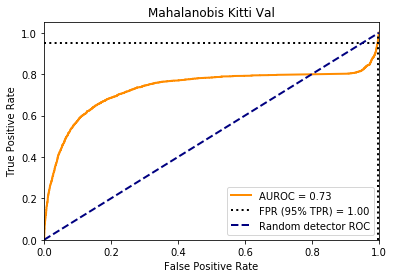

{'fpr_at_95_tpr': 0.9964049747376603, 'detection_error': 0.5, 'auroc': 0.7314998947045821, 'aupr_in': 0.5878001323311162, 'aupr_out': 0.8231857838244367}


In [75]:
plot_roc(kitti_val_novelty_scores, kitti_val_y, title="Mahalanobis Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD val

In [76]:
%reset -f array

In [77]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

idd_val_novelty_scores, idd_val_y = chunked_calc(
    read_features, [save_path, 4], save_path, md, 1000)

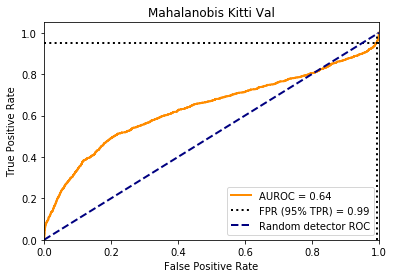

{'fpr_at_95_tpr': 0.992994179780125, 'detection_error': 0.5, 'auroc': 0.6363480662662663, 'aupr_in': 0.2678367297252634, 'aupr_out': 0.8986956308645376}


In [78]:
plot_roc(idd_val_novelty_scores, idd_val_y, title="Mahalanobis Kitti Val")
print(calc_metrics(idd_val_novelty_scores, idd_val_y))